# Image analytics code

This code is used to advance a step by step analysis of similarities, isotopies and structural homologies between images.

## Import Libraries

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import base64
import io
from PIL import Image, ImageDraw

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from skimage.measure import shannon_entropy
from skimage.feature import canny
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
from skimage.io import imread
from skimage.util import img_as_ubyte


## Load all images from the directory

In [2]:
def load_images_from_directory(directory, target_size=(224, 224)):
    image_paths = glob.glob(os.path.join(directory, "*"))
    supported_formats = (".jpg", ".jpeg", ".png")
    images = []
    filenames = []
    for path in image_paths:
        if path.lower().endswith(supported_formats):
            try:
                with Image.open(path) as img:
                    img = img.convert("RGB")
                    img_resized = img.resize(target_size)
                    images.append(np.array(img_resized))
                    filenames.append(os.path.basename(path))
            except Exception as e:
                print(f"Error loading {path}: {e}")
    return np.stack(images), filenames

# Load images and filenames
image_directory = os.path.join(os.getcwd(), "images")  # Subdirectory 'images'
image_dataset, file_names = load_images_from_directory(image_directory)


In [3]:
# Preprocess the images for VGG-16
image_dataset_preprocessed = preprocess_input(image_dataset)

In [4]:
# Load VGG-16 and extract features
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
features = vgg16_model.predict(image_dataset_preprocessed, batch_size=32)

# Check the shape of the extracted features
print(f"Extracted features shape: {features.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Extracted features shape: (8, 7, 7, 512)


In [5]:
# Flatten the features for similarity calculations
flattened_features = features.reshape(features.shape[0], -1)


In [6]:
# Step 3: Compute pairwise similarity
similarity_matrix = cosine_similarity(flattened_features)

In [7]:
# Check the similarity matrix
print("Pairwise Similarity Matrix:")
print(similarity_matrix)

Pairwise Similarity Matrix:
[[0.9999999  0.2233504  0.20617723 0.10072597 0.22022685 0.17171848
  0.28411305 0.26180077]
 [0.2233504  1.0000004  0.21373162 0.15177183 0.34799278 0.19655344
  0.31978348 0.312866  ]
 [0.20617723 0.21373162 0.9999999  0.24885713 0.2201224  0.3441021
  0.16733603 0.18731013]
 [0.10072597 0.15177183 0.24885713 1.0000002  0.20519042 0.21951593
  0.1271105  0.1469092 ]
 [0.22022685 0.34799278 0.2201224  0.20519042 1.         0.16638862
  0.24103142 0.262398  ]
 [0.17171848 0.19655344 0.3441021  0.21951593 0.16638862 1.
  0.14260787 0.17422205]
 [0.28411305 0.31978348 0.16733603 0.1271105  0.24103142 0.14260787
  1.0000001  0.3210019 ]
 [0.26180077 0.312866   0.18731013 0.1469092  0.262398   0.17422205
  0.3210019  1.        ]]


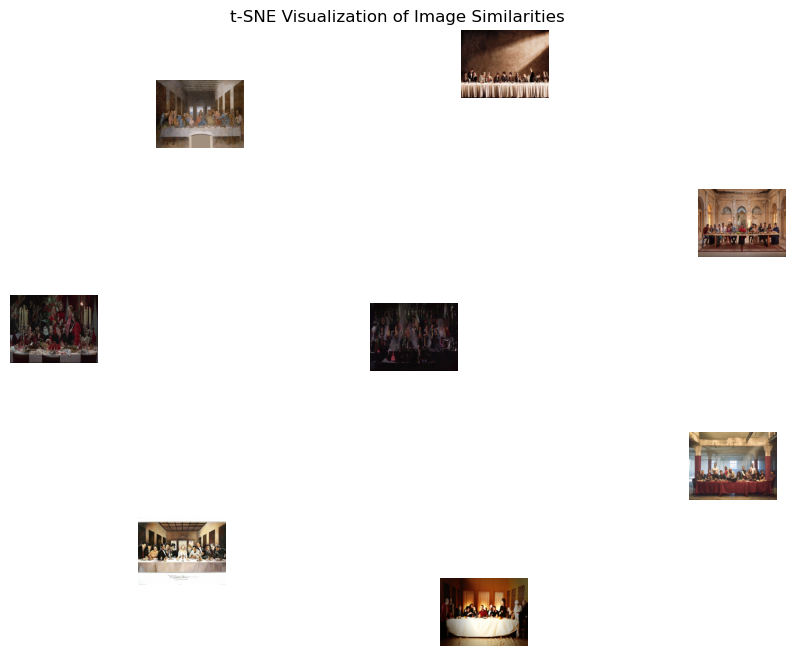

In [9]:
# Step 4: Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(file_names) - 1))
reduced_features = tsne.fit_transform(flattened_features)

plt.figure(figsize=(10, 8))
# Define the size of the rectangles for the images
# Change size to adjust in the diagram
image_display_width = 20  # Horizontal size of the image
image_display_height = 20  # Vertical size of the image

# Plot each image as a rectangle in the reduced feature space
for i, (x, y) in enumerate(reduced_features):
    img = image_dataset[i]
    img = img / 255.0  # Normalize for proper visualization
    # Calculate the rectangle's bounds
    x_min = x - image_display_width / 2
    x_max = x + image_display_width / 2
    y_min = y - image_display_height / 2
    y_max = y + image_display_height / 2
    # Display the image as a rectangle
    plt.imshow(img, extent=(x_min, x_max, y_min, y_max), zorder=2, aspect='auto')
    plt.scatter(x, y, zorder=1, edgecolor='black', s=0)  # Add a marker (hidden)

plt.title("t-SNE Visualization of Image Similarities")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.axis('off')  # Clean visualization
plt.show()

In [10]:
# Prepare scatter data
scatter_data = pd.DataFrame({
    "x": reduced_features[:, 0],
    "y": reduced_features[:, 1],
    "Filename": file_names
})

# Function to encode an image as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded = base64.b64encode(image_file.read()).decode()
    return f"data:image/jpeg;base64,{encoded}"

# Add encoded images to scatter_data
scatter_data["Encoded_Image"] = [encode_image(os.path.join(image_directory, filename)) for filename in file_names]

# Create interactive scatterplot
fig = px.scatter(
    scatter_data,
    x="x",
    y="y",
    title="t-SNE Visualization: Image Similarities",
    hover_data={"Filename": True}
)

# Overlay images on scatterplot
for i, row in scatter_data.iterrows():
    fig.add_layout_image(
        dict(
            source=row["Encoded_Image"],
            x=row["x"],
            y=row["y"],
            xref="x",
            yref="y",
            sizex=20,  # Adjust image size
            sizey=20,  # Adjust image size
            xanchor="center",
            yanchor="middle",
            layer="above"
        )
    )

# Save the scatterplot as an HTML file
fig.write_html("image_similarity_scatterplot.html")
print("Scatterplot saved as 'image_similarity_scatterplot.html'. Open this file in a browser to view the visualization.")

Scatterplot saved as 'image_similarity_scatterplot.html'. Open this file in a browser to view the visualization.


## a. Low-Level (Plastic) Similarity

**Definition:** Based on color, texture, edges, and entropy.</p>
**Interpretation:** Images close together in this context might share similar overall tones, patterns, or textural qualities.</p>
**Measurement:**</br>
	•	Use the *first convolutional block* of VGG-16.</br>
	•	Extract features like color histograms or edge distributions.</p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


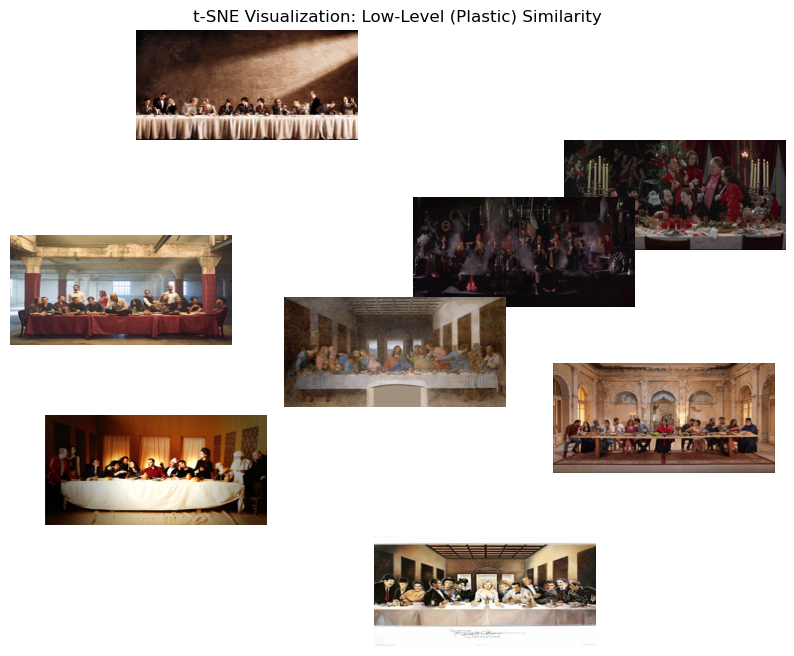

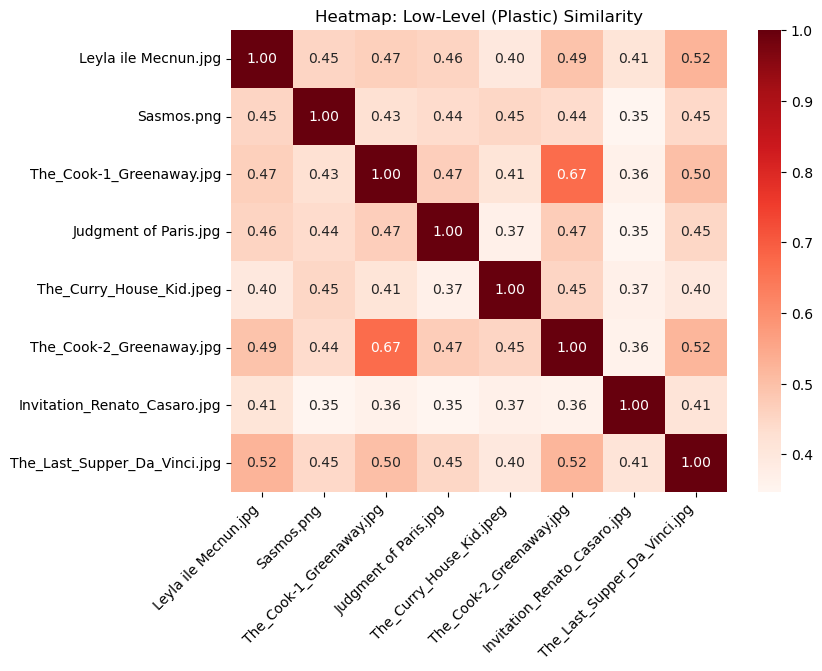

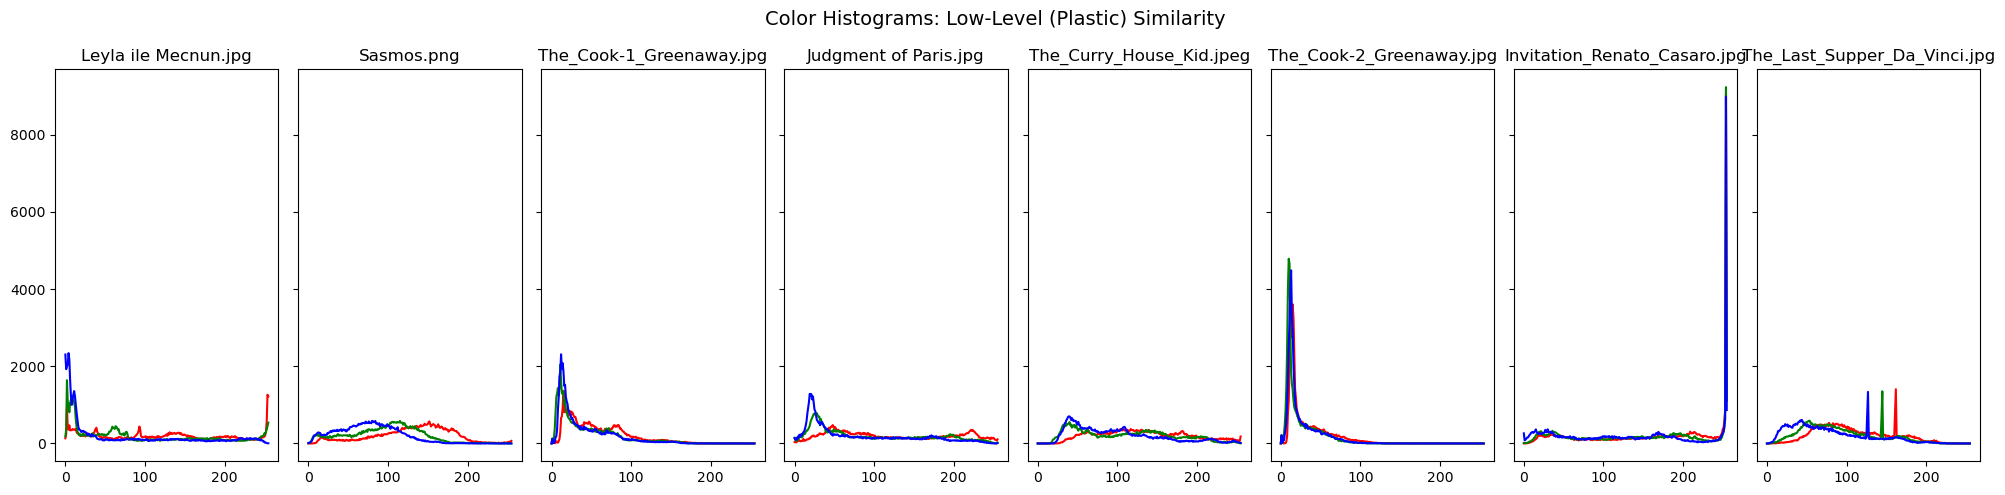

In [11]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Step 2: Load the VGG-16 model and extract low-level features
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
layer_name = 'block1_conv2'  # Second convolutional layer in the first block
model_block1 = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer(layer_name).output)

# Predict once, avoiding retracing warnings
low_level_features = model_block1.predict(image_dataset_preprocessed, batch_size=len(image_dataset_preprocessed))

# Flatten features for similarity calculations
low_level_features_flat = low_level_features.reshape(low_level_features.shape[0], -1)

# Step 3: Compute pairwise similarity
low_level_similarity_matrix = cosine_similarity(low_level_features_flat)

# Step 4: Dimensionality reduction with t-SNE
tsne_low_level = TSNE(n_components=2, random_state=42, perplexity=2)
low_level_tsne = tsne_low_level.fit_transform(low_level_features_flat)

# Step 5: Scatterplot visualization
# Dynamic scaling for t-SNE coordinates
x_coords = low_level_tsne[:, 0]
y_coords = low_level_tsne[:, 1]
x_range = x_coords.max() - x_coords.min()
y_range = y_coords.max() - y_coords.min()

# Experiment with a smaller fraction for display size
image_display_size = min(x_range, y_range) / 5  # Adjust fraction if needed

plt.figure(figsize=(10, 8))

# Overlay images and markers for debugging
for i, (x, y) in enumerate(low_level_tsne):
    img = image_dataset[i]
    img = img / 255.0  # Normalize for display
    plt.imshow(img, extent=(x - image_display_size, x + image_display_size,
                            y - image_display_size, y + image_display_size), zorder=2, aspect='auto')
    # Debugging marker
    plt.scatter(x, y, c='red', s=10, zorder=1)  # Small red markers for verification

plt.title("t-SNE Visualization: Low-Level (Plastic) Similarity")
plt.axis('off')  # Clean visualization
plt.show()

# Step 6. Heatmap visualization with filenames
plt.figure(figsize=(8, 6))
sns.heatmap(
    low_level_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    xticklabels=[file_names.split('/')[-1] for file_names in file_names],
    yticklabels=[file_names.split('/')[-1] for file_names in file_names]
)
plt.title("Heatmap: Low-Level (Plastic) Similarity")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()

# Step 7: Color histograms for each image
fig, axes = plt.subplots(1, len(image_dataset), figsize=(20, 5), sharey=True)
for i, ax in enumerate(axes):
    img = image_dataset[i]
    colors = ('r', 'g', 'b')
    for j, color in enumerate(colors):
        hist, bins = np.histogram(img[:, :, j].flatten(), bins=256, range=(0, 256))
        ax.plot(bins[:-1], hist, color=color)
    # Use the actual filename as the title
    ax.set_title(file_names[i], fontsize=12)  # Shorter filenames, adjusted font size

plt.suptitle("Color Histograms: Low-Level (Plastic) Similarity", fontsize=14)
plt.tight_layout()
plt.show()

## Reading Color Histograms

A color histogram represents the distribution of pixel intensity values for each color channel (Red, Green, and Blue) in an image. It shows how frequently each intensity (0 to 255) occurs.</p>

**Key Points for Interpretation:**</br>
	1.	Axes:</br>
	•	X-Axis: Intensity values (0 = dark, 255 = bright).</br>
	•	Y-Axis: Frequency of pixels at each intensity level.</br>
	2.	Peaks and Troughs:</br>
	•	Peaks: Indicate dominant intensity ranges (e.g., a high peak near 255 in the red channel means the image has a lot of bright red).</br>
	•	Troughs: Indicate low-frequency intensity ranges.</br>
	3.	Comparison Between Channels:</br>
	•	Similar shapes across channels suggest balanced colors.</br>
	•	Distinctly different distributions indicate color dominance or bias.</br>
	4.	Flat Histograms:</br>
	•	Indicate evenly distributed intensity values (e.g., noisy or high-entropy images).</br>
	5.	Sharp Peaks:</br>
	•	Suggest dominant colors or low entropy (e.g., an image with large uniform regions of a single color).</br>

### Entropy Measurement

Entropy quantifies the amount of information or randomness in an image. High entropy implies more detail or noise, while low entropy suggests uniform regions.

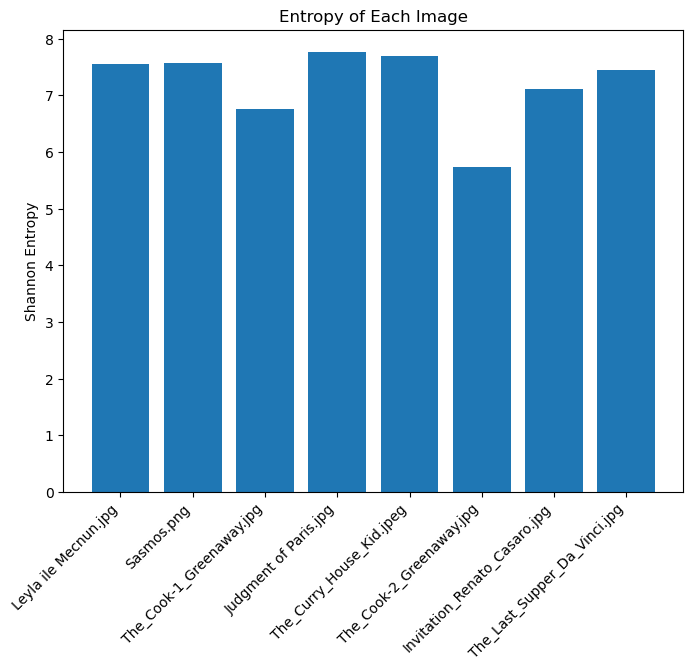

In [12]:
# Compute and visualize entropy for each image
entropy_values = [shannon_entropy(img) for img in image_dataset]

# Bar chart for entropy
plt.figure(figsize=(8, 6))
plt.bar(range(len(image_dataset)), entropy_values, tick_label=file_names)  # Use file_names for labels
plt.title("Entropy of Each Image")
plt.ylabel("Shannon Entropy")
plt.xticks(rotation=45, ha='right')
plt.show()

### Texture measurement

To visualize texture measurements, we can use several techniques. Below, I’ll provide two common approaches: edge detection and Gray-Level Co-Occurrence Matrix (GLCM) analysis. These techniques provide insights into the texture patterns and spatial relationships within an image.

**Edge Detection**</p>

Edge detection highlights boundaries and texture patterns by identifying significant intensity changes in an image. We will visualize the edge-detected images and compute edge density.

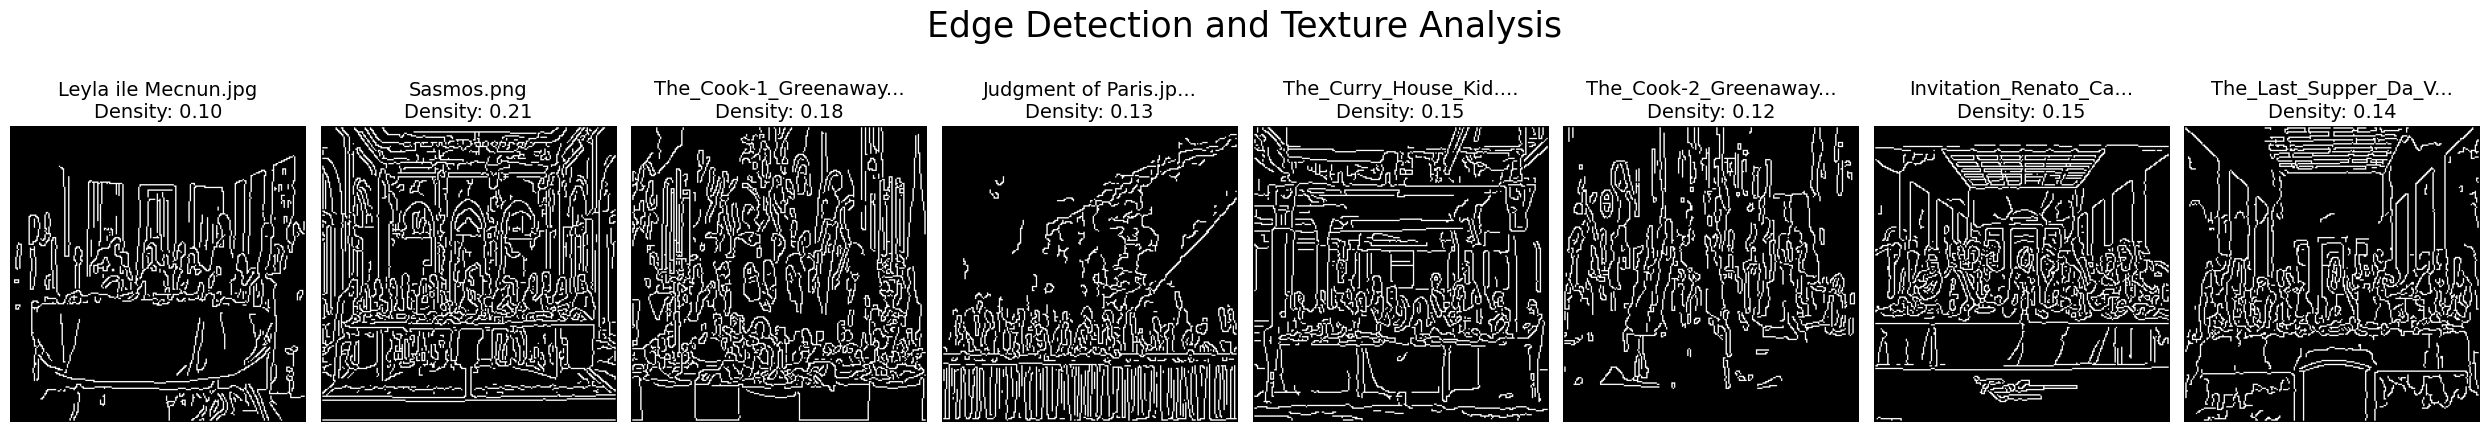

In [13]:
# Compute edge detection and visualize edge-detected images
plt.figure(figsize=(25, 5))  # Increased figure width
for i, img in enumerate(image_dataset):
    gray_img = rgb2gray(img / 255.0)  # Convert to grayscale
    edges = canny(gray_img)  # Apply Canny edge detection
    edge_density = np.sum(edges) / edges.size  # Compute edge density
    
    # Plot edge-detected image
    plt.subplot(1, len(image_dataset), i + 1)
    plt.imshow(edges, cmap='gray')
    # Use filenames as titles, truncated if necessary
    truncated_name = file_names[i] if len(file_names[i]) <= 20 else file_names[i][:20] + "..."
    plt.title(f"{truncated_name}\nDensity: {edge_density:.2f}", fontsize=14)  # Reduced font size
    plt.axis('off')

plt.suptitle("Edge Detection and Texture Analysis", fontsize=25)  # Larger title
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**GLCM Texture Analysis**</p>

The Gray-Level Co-Occurrence Matrix (GLCM) is a statistical method that evaluates spatial relationships between pixel intensities in an image. From the GLCM, we can compute texture properties such as contrast, correlation, energy, and homogeneity.

**1. Contrast**</br>
*Definition:* Measures the intensity difference between a pixel and its neighbors across the entire image.</br>
*Interpretation:*</br>
	•	High Contrast (closer to 1): Indicates sharp variations in intensity, often associated with detailed or textured regions (e.g., edges, fine patterns).</br>
	•	Low Contrast (closer to 0): Indicates smooth regions with little variation in intensity.</br>
*Example:*</br>
	•	An image with many sharp edges and texture (e.g., a forest) will have higher contrast.</br>
	•	A uniformly shaded area (e.g., a clear sky) will have lower contrast.</p>

**2. Energy**</br>
*Definition:* Measures the uniformity or orderliness of the intensity distribution in the image. It is the sum of squared values in the GLCM matrix.</br>
*Interpretation:*</br>
	•	High Energy (closer to 1): Indicates a highly uniform image, often with large, consistent areas of similar intensity.</br>
	•	Low Energy (closer to 0): Indicates a more heterogeneous or disordered image.</br>
*Example:*</br>
	•	A smooth, uniform image (e.g., a solid-colored background) will have high energy.</br>
	•	A noisy or highly detailed image will have lower energy.</p>

**3. Homogeneity**</br>
*Definition:* Measures the closeness of the distribution of elements in the GLCM matrix to the diagonal, which corresponds to similar intensity values between neighboring pixels.</br>
*Interpretation:*</br>
	•	High Homogeneity (closer to 1): Indicates that neighboring pixels have similar intensities, often found in smooth or gradual transitions.</br>
	•	Low Homogeneity (closer to 0): Indicates a lack of similarity between neighboring pixels, often found in rough or highly detailed textures.</br>
*Example:*</br>
	•	A smooth gradient (e.g., a soft shadow) will have high homogeneity.</br>
	•	A complex texture (e.g., sand or fabric) will have lower homogeneity.</p>

In [14]:
def compute_glcm_custom(image, distances=[1], angles=[0]):
    """Compute a Gray Level Co-occurrence Matrix (GLCM) manually."""
    gray_levels = 256  # Assumes image is already grayscale and 8-bit
    glcm = np.zeros((gray_levels, gray_levels), dtype=np.float64)

    # Offset for each angle
    offsets = [(int(np.round(np.cos(angle))), int(np.round(np.sin(angle)))) for angle in angles]

    for offset in offsets:
        for d in distances:
            row_offset, col_offset = d * offset[0], d * offset[1]

            for row in range(image.shape[0] - row_offset):
                for col in range(image.shape[1] - col_offset):
                    current_pixel = image[row, col]
                    neighbor_pixel = image[row + row_offset, col + col_offset]
                    glcm[current_pixel, neighbor_pixel] += 1

    glcm = glcm / glcm.sum()  # Normalize the GLCM
    return glcm

In [15]:
def compute_glcm_features_custom(image):
    """Compute texture features from the custom GLCM."""
    glcm = compute_glcm_custom(image)

    # Contrast
    contrast = sum((i - j) ** 2 * glcm[i, j] for i in range(glcm.shape[0]) for j in range(glcm.shape[1]))

    # Energy
    energy = np.sum(glcm ** 2)

    # Homogeneity
    homogeneity = sum(glcm[i, j] / (1 + abs(i - j)) for i in range(glcm.shape[0]) for j in range(glcm.shape[1]))

    return contrast, energy, homogeneity

In [16]:
# Convert images to grayscale and compute GLCM features
texture_features = []
for img in image_dataset:
    gray_image = img_as_ubyte(rgb2gray(img))
    features = compute_glcm_features_custom(gray_image)
    texture_features.append(features)

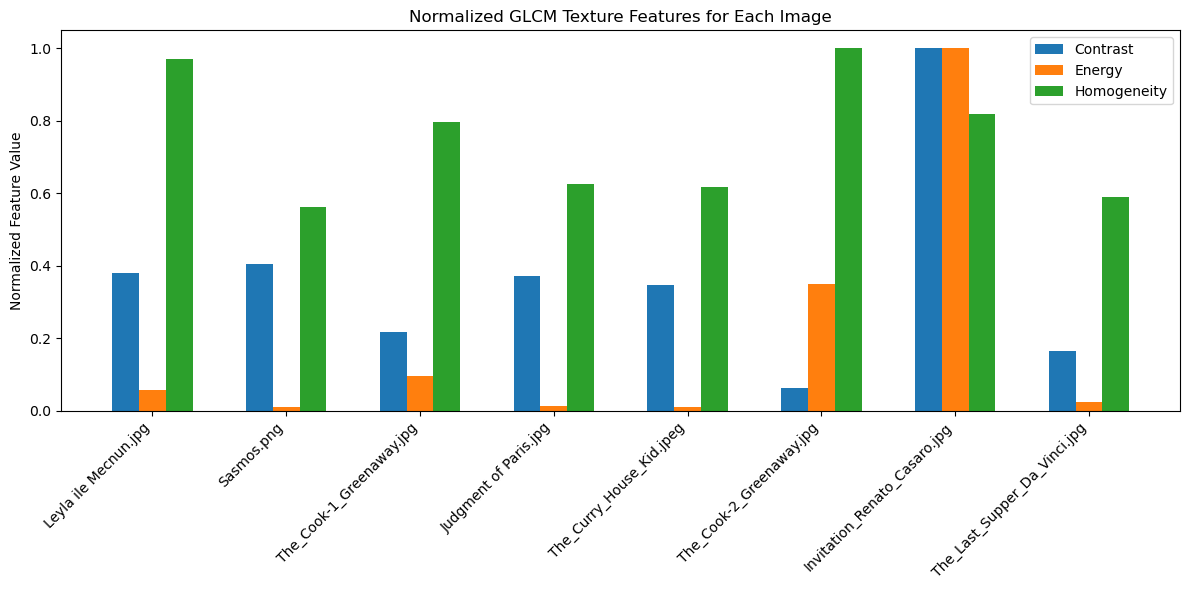

In [17]:
# Convert texture features to a NumPy array
texture_features = np.array(texture_features)

# Normalize features for visualization
normalized_features = texture_features / texture_features.max(axis=0)

plt.figure(figsize=(12, 6))
x = np.arange(len(image_dataset))  # Number of images
width = 0.2  # Width of each bar

labels = ["Contrast", "Energy", "Homogeneity"]

# Plot bars for each feature
for i, label in enumerate(labels):
    plt.bar(x + i * width, normalized_features[:, i], width=width, label=label)

# Add filenames as x-axis labels
plt.xticks(x + width, file_names, rotation=45, ha='right')  # Use file_names for labels
plt.ylabel("Normalized Feature Value")
plt.title("Normalized GLCM Texture Features for Each Image")
plt.legend()
plt.tight_layout()  # Adjust layout
plt.show()

## b. Formal Similarity
**Definition:** Compositional or structural similarities such as arrangements of elements, spatial relationships, and forms.</p>
**Interpretation:** Images close in this context might have similar arrangements (e.g., symmetry, alignment).</p>
**Measurement:**</br>
	•	Use *mid-level layers* of VGG-16.</br>
	•	Compute relationships between object positions and shapes.</p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


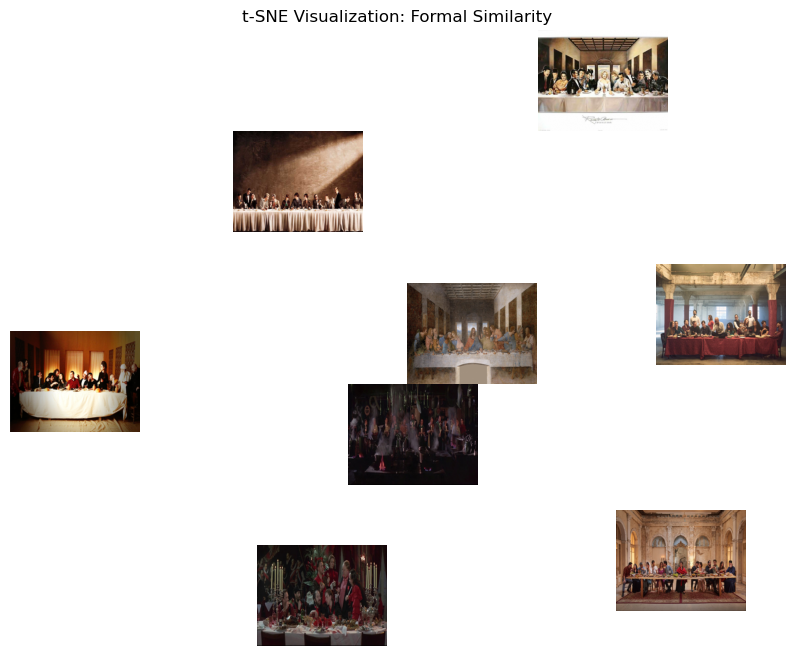

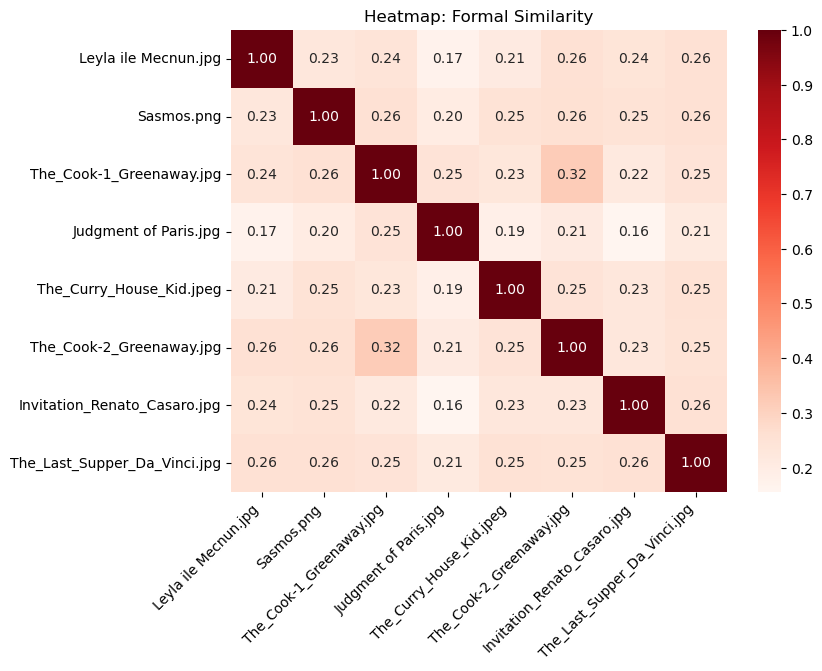

In [18]:

# Step 1: Extract features from a mid-level layer of VGG-16
layer_name = 'block3_conv3'  # Mid-level layer for structural features
model_block3 = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer(layer_name).output)

# Predict features for the dataset
formal_features = model_block3.predict(image_dataset_preprocessed, batch_size=len(image_dataset_preprocessed))

# Flatten features for similarity calculations
formal_features_flat = formal_features.reshape(formal_features.shape[0], -1)

# Step 2: Compute pairwise cosine similarity
formal_similarity_matrix = cosine_similarity(formal_features_flat)

# Step 3: Dimensionality reduction with t-SNE
tsne_formal = TSNE(n_components=2, random_state=42, perplexity=2)
formal_tsne = tsne_formal.fit_transform(formal_features_flat)

# Step 4: Scatterplot visualization
plt.figure(figsize=(10, 8))
x_coords = formal_tsne[:, 0]
y_coords = formal_tsne[:, 1]
x_range = x_coords.max() - x_coords.min()
y_range = y_coords.max() - y_coords.min()

# Adjust image display size dynamically
image_display_size = min(x_range, y_range) / 10

for i, (x, y) in enumerate(formal_tsne):
    img = image_dataset[i]
    img = img / 255.0  # Normalize for display
    plt.imshow(img, extent=(x - image_display_size, x + image_display_size,
                            y - image_display_size, y + image_display_size), zorder=2, aspect='auto')
    plt.scatter(x, y, c='red', s=10, zorder=1)  # Small red markers for verification

plt.title("t-SNE Visualization: Formal Similarity")
plt.axis('off')
plt.show()

# Step 5: Heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(
    formal_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    xticklabels=[file_names.split('/')[-1] for file_names in file_names],
    yticklabels=[file_names.split('/')[-1] for file_names in file_names]
)
plt.title("Heatmap: Formal Similarity")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**Symmetry Detection**

Symmetry can be analyzed by comparing the left and right halves (or top and bottom halves) of the feature maps.

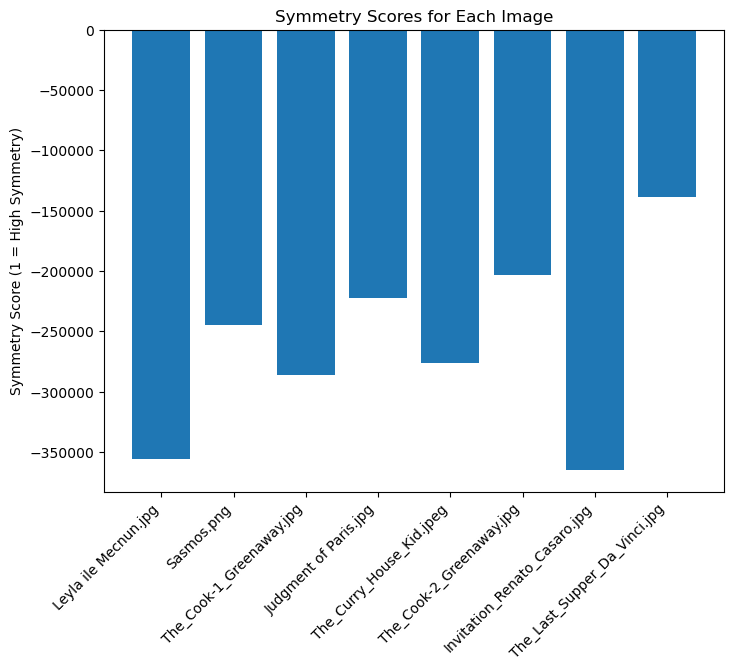

In [19]:
# Function to compute symmetry score
def compute_symmetry_score(feature_map):
    # Split feature map into left and right halves
    left_half = feature_map[:, :feature_map.shape[1] // 2]
    right_half = feature_map[:, feature_map.shape[1] // 2:]
    # Flip right half horizontally
    right_half_flipped = np.flip(right_half, axis=1)
    
    # Compute similarity between left and flipped right halves
    symmetry_score = np.mean((left_half - right_half_flipped) ** 2)
    return 1 - symmetry_score  # Closer to 1 indicates high symmetry

# Compute symmetry scores for each image
symmetry_scores = [compute_symmetry_score(formal_features[i]) for i in range(formal_features.shape[0])]

# Bar chart to visualize symmetry scores
plt.figure(figsize=(8, 6))
plt.bar(range(len(image_dataset)), symmetry_scores, tick_label=[file_names.split('/')[-1] for file_names in file_names])
plt.title("Symmetry Scores for Each Image")
plt.ylabel("Symmetry Score (1 = High Symmetry)")
plt.xticks(rotation=45, ha='right')
plt.show()

**Region-Specific Analysis**

We can focus on specific regions (e.g., center, periphery) by masking parts of the feature map and recomputing similarity or analyzing arrangements within those regions.

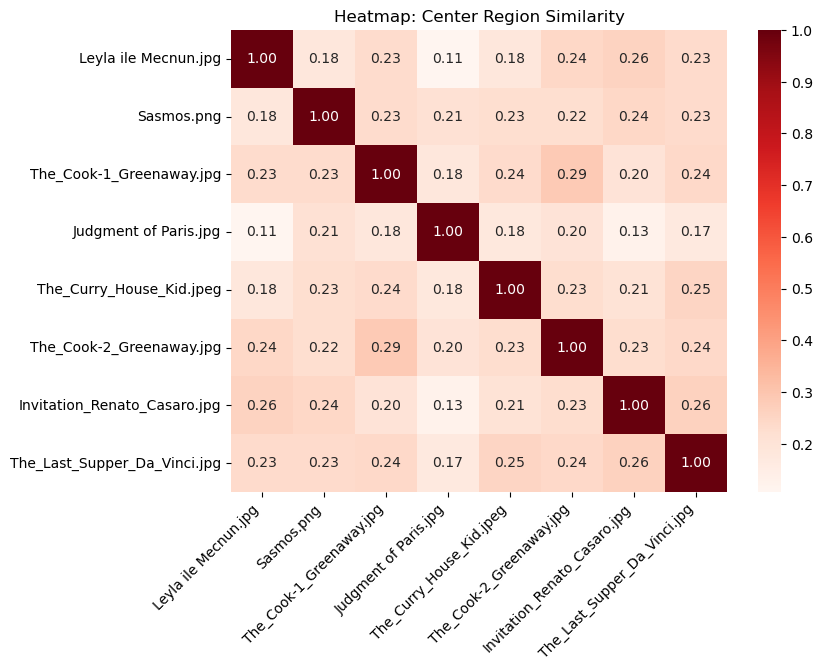

In [20]:
# Function to extract center region of the feature map
def extract_center_region(feature_map, size_ratio=0.5):
    # Calculate center region coordinates
    center_x, center_y = feature_map.shape[0] // 2, feature_map.shape[1] // 2
    size_x, size_y = int(feature_map.shape[0] * size_ratio), int(feature_map.shape[1] * size_ratio)
    # Extract the center region
    center_region = feature_map[
        center_x - size_x // 2:center_x + size_x // 2,
        center_y - size_y // 2:center_y + size_y // 2
    ]
    return center_region

# Compute similarity based on center regions
center_features = [extract_center_region(formal_features[i]) for i in range(formal_features.shape[0])]
center_features_flat = [region.flatten() for region in center_features]
center_similarity_matrix = cosine_similarity(center_features_flat)

# Visualize center region similarity heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    center_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    xticklabels=[file_names.split('/')[-1] for file_names in file_names],
    yticklabels=[file_names.split('/')[-1] for file_names in file_names]
)
plt.title("Heatmap: Center Region Similarity")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

## c. Foreground/Background Similarity
**Definition:** Similarity confined to specific regions (e.g., main subjects vs. surroundings).</p>
**Interpretation:** Images close in this context might have similar objects in the foreground or comparable background elements.</p>
**Measurement:**</br>
	•	Use *region-specific masking* during feature extraction.</br>
	•	Analyze differences between segmented foreground and background features.</p>

**Saliency Detection or Simple Foreground Segmentation**

For simplicity, we’ll threshold pixel intensities to approximate the foreground.

In [21]:
# Function to separate foreground and background using simple thresholding
def segment_foreground(image):
    gray_image = rgb2gray(image / 255.0)  # Convert to grayscale
    threshold = threshold_otsu(gray_image)  # Compute Otsu's threshold
    mask = gray_image > threshold  # Foreground mask
    foreground = image * mask[..., np.newaxis]  # Apply mask to extract foreground
    background = image * (~mask)[..., np.newaxis]  # Apply inverted mask for background
    return foreground, background

# Segment foreground and background for each image
foregrounds = []
backgrounds = []
for img in image_dataset:
    fg, bg = segment_foreground(img)
    foregrounds.append(fg)
    backgrounds.append(bg)
foregrounds = np.array(foregrounds)
backgrounds = np.array(backgrounds)

In [22]:
# Preprocess foregrounds and backgrounds for VGG-16
foregrounds_preprocessed = preprocess_input(foregrounds)
backgrounds_preprocessed = preprocess_input(backgrounds)

# Extract features for foregrounds and backgrounds
foreground_features = model_block3.predict(foregrounds_preprocessed, batch_size=len(foregrounds_preprocessed))
background_features = model_block3.predict(backgrounds_preprocessed, batch_size=len(backgrounds_preprocessed))

# Flatten features for similarity calculations
foreground_features_flat = foreground_features.reshape(foreground_features.shape[0], -1)
background_features_flat = background_features.reshape(background_features.shape[0], -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


In [23]:
# Compute similarity matrices
foreground_similarity_matrix = cosine_similarity(foreground_features_flat)
background_similarity_matrix = cosine_similarity(background_features_flat)

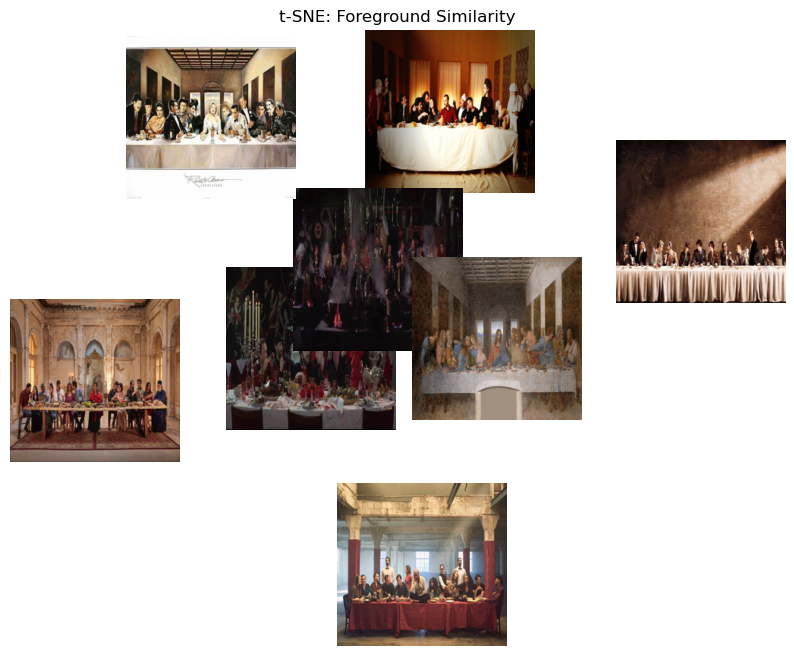

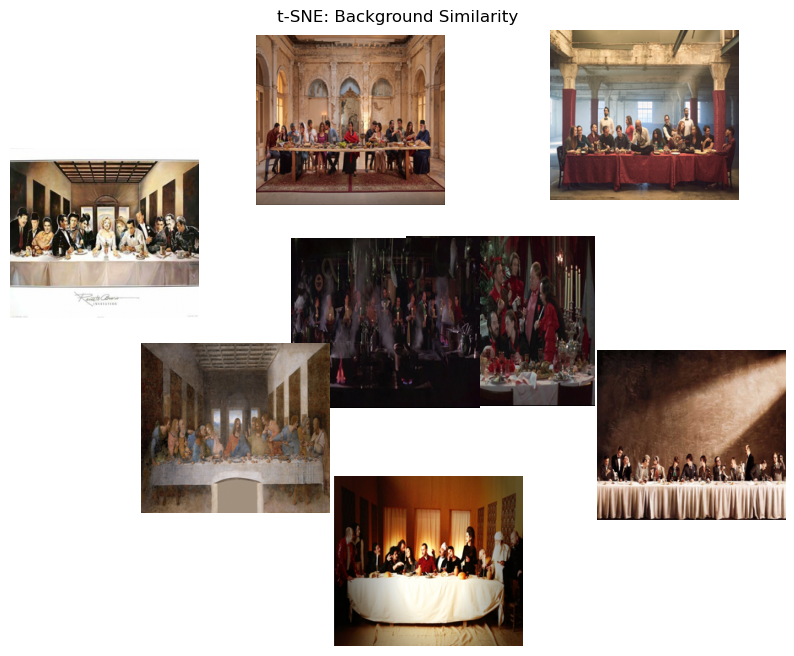

In [24]:
# t-SNE for foreground
tsne_foreground = TSNE(n_components=2, random_state=42, perplexity=2)
foreground_tsne = tsne_foreground.fit_transform(foreground_features_flat)

plt.figure(figsize=(10, 8))

# Adjust this value to control the display size of images
image_display_size = 20  # Increase this value to make images larger

for i, (x, y) in enumerate(foreground_tsne):
    img = image_dataset[i]
    img = img / 255.0  # Normalize for display
    plt.imshow(img, extent=(x - image_display_size, x + image_display_size,
                            y - image_display_size, y + image_display_size), zorder=2, aspect='auto')
    plt.scatter(x, y, c='red', s=10, zorder=1)  # Debug marker

plt.title("t-SNE: Foreground Similarity")
plt.axis('off')
plt.show()

# t-SNE for background
tsne_background = TSNE(n_components=2, random_state=42, perplexity=2)
background_tsne = tsne_background.fit_transform(background_features_flat)

plt.figure(figsize=(10, 8))

# Adjust this value to control the display size of images
image_display_size = 20  # Increase this value to make images larger

for i, (x, y) in enumerate(background_tsne):
    img = image_dataset[i]
    img = img / 255.0  # Normalize for display
    plt.imshow(img, extent=(x - image_display_size, x + image_display_size,
                            y - image_display_size, y + image_display_size), zorder=2, aspect='auto')
    plt.scatter(x, y, c='red', s=10, zorder=1)  # Debug marker

plt.title("t-SNE: Background Similarity")
plt.axis('off')
plt.show()

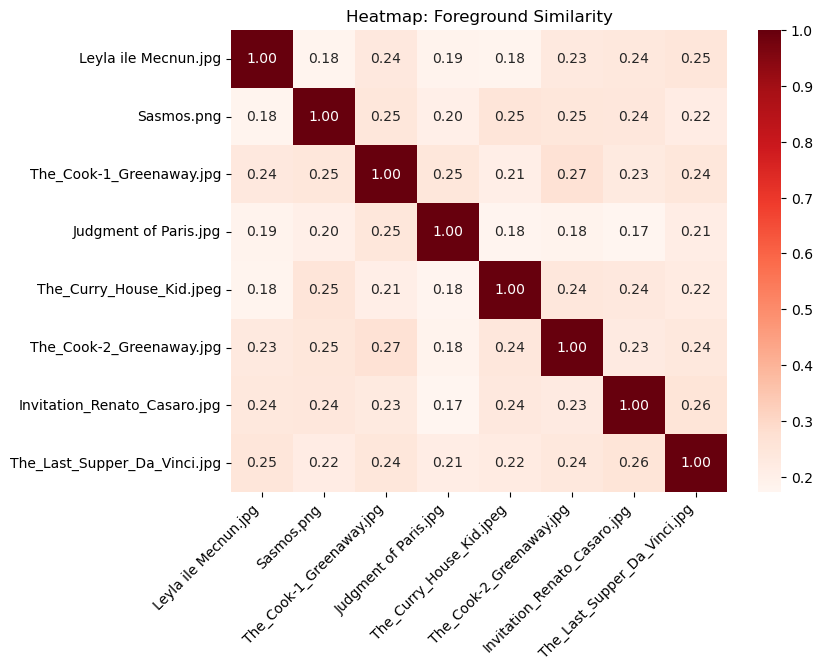

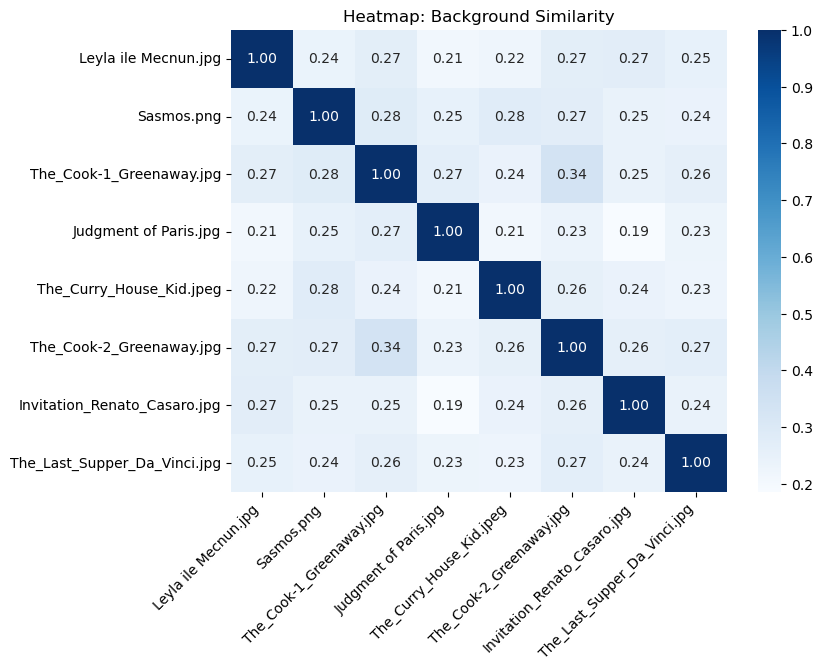

In [32]:
# Heatmap for foreground similarity
plt.figure(figsize=(8, 6))
sns.heatmap(
    foreground_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    xticklabels=[file_names.split('/')[-1] for file_names in file_names],
    yticklabels=[file_names.split('/')[-1] for file_names in file_names]
)
plt.title("Heatmap: Foreground Similarity")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Heatmap for background similarity
plt.figure(figsize=(8, 6))
sns.heatmap(
    background_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[file_names.split('/')[-1] for file_names in file_names],
    yticklabels=[file_names.split('/')[-1] for file_names in file_names]
)
plt.title("Heatmap: Background Similarity")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

## d. Semantic (High-Level) Similarity
**Definition:** Based on the meaning or theme of the images.</p>
**Interpretation:** Images close in this context might depict similar concepts or activities.</p>
**Measurement:**</br>
	•	Use deepest layers of VGG-16 for abstract representations.</p>

In [33]:
# Extract features from the deepest convolutional layer of VGG-16
layer_name = 'block5_conv3'  # Deep layer for high-level semantics
model_block5 = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer(layer_name).output)

# Predict features for the dataset
semantic_features = model_block5.predict(image_dataset_preprocessed, batch_size=len(image_dataset_preprocessed))

# Flatten features for similarity calculations
semantic_features_flat = semantic_features.reshape(semantic_features.shape[0], -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


In [34]:
# Compute pairwise similarity using cosine similarity
semantic_similarity_matrix = cosine_similarity(semantic_features_flat)

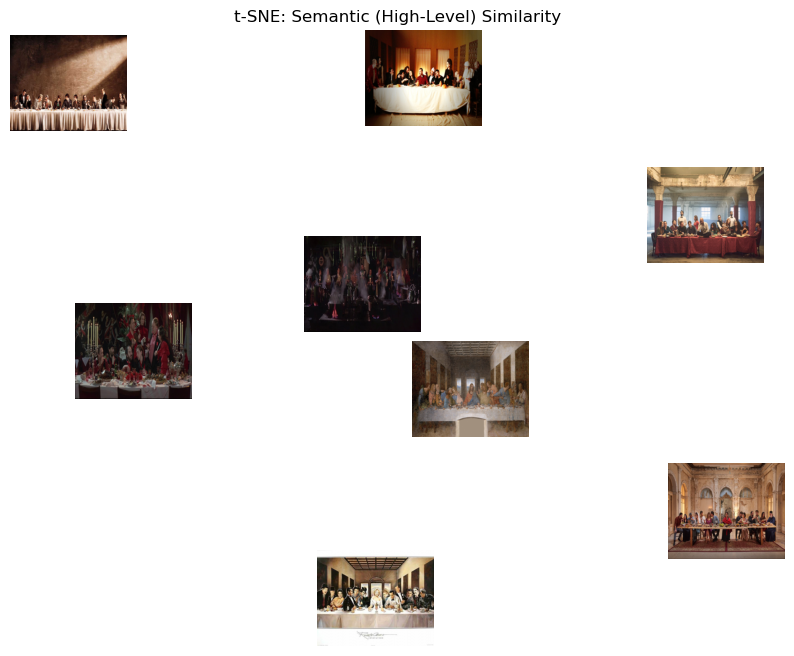

In [35]:
# Dimensionality reduction using t-SNE
tsne_semantic = TSNE(n_components=2, random_state=42, perplexity=2)
semantic_tsne = tsne_semantic.fit_transform(semantic_features_flat)

# Scatterplot
plt.figure(figsize=(10, 8))

# Adjust this value to control the size of displayed images
image_display_size = 10

for i, (x, y) in enumerate(semantic_tsne):
    img = image_dataset[i]
    img = img / 255.0  # Normalize for display
    plt.imshow(img, extent=(x - image_display_size, x + image_display_size,
                            y - image_display_size, y + image_display_size), zorder=2, aspect='auto')
    plt.scatter(x, y, c='red', s=10, zorder=1)  # Debug marker

plt.title("t-SNE: Semantic (High-Level) Similarity")
plt.axis('off')
plt.show()

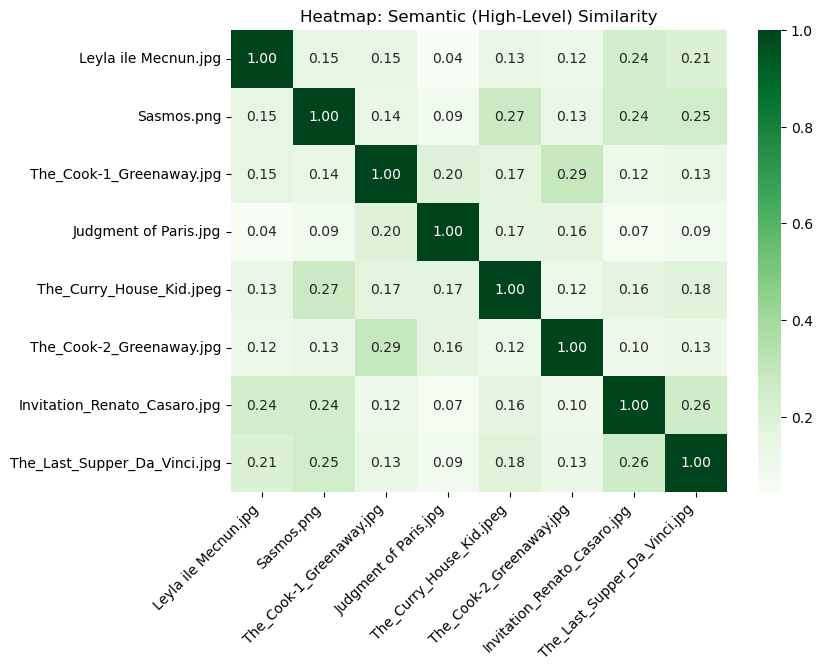

In [36]:
# Heatmap for semantic similarity
plt.figure(figsize=(8, 6))
sns.heatmap(
    semantic_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=[file_names.split('/')[-1] for file_names in file_names],
    yticklabels=[file_names.split('/')[-1] for file_names in file_names]
)
plt.title("Heatmap: Semantic (High-Level) Similarity")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**Object or Theme Clustering**

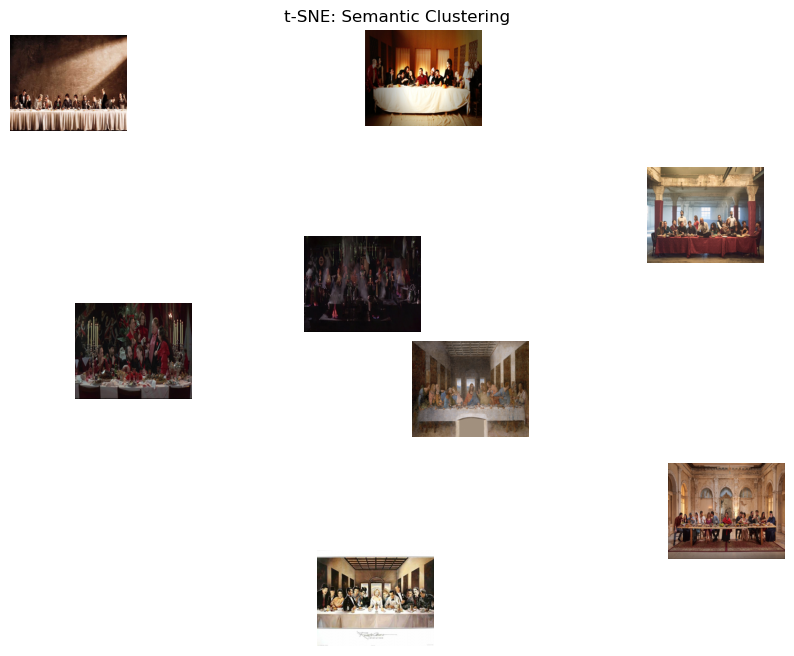

In [37]:
from sklearn.cluster import KMeans

# Perform k-means clustering on the semantic features
num_clusters = 3  # Adjust based on the number of expected clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(semantic_features_flat)

# Scatterplot with cluster labels
plt.figure(figsize=(10, 8))

# Adjust this value to control the size of displayed images
image_display_size = 10

for i, (x, y) in enumerate(semantic_tsne):
    img = image_dataset[i]
    img = img / 255.0  # Normalize for display
    plt.imshow(img, extent=(x - image_display_size, x + image_display_size,
                            y - image_display_size, y + image_display_size), zorder=2, aspect='auto')
    plt.scatter(x, y, c=f"C{cluster_labels[i]}", s=10, zorder=1)  # Color by cluster label

plt.title("t-SNE: Semantic Clustering")
plt.axis('off')
plt.show()

**UMAP for Scatterplot**

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


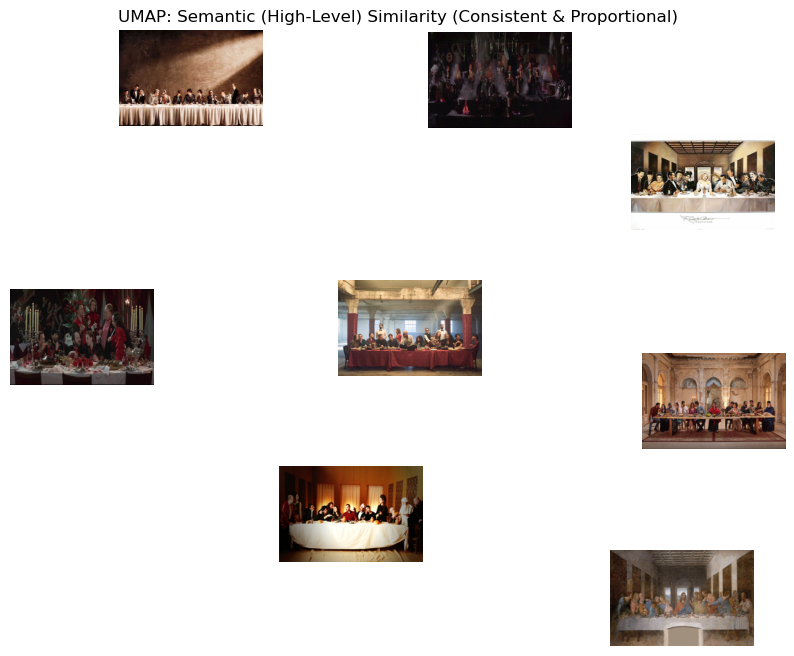

In [38]:
from umap import UMAP
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress user warnings


# Dimensionality reduction using UMAP
umap_semantic = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
semantic_umap = umap_semantic.fit_transform(semantic_features_flat)

# Scatterplot with UMAP
plt.figure(figsize=(10, 8))

# Adjust this value for the base size of images
image_display_base_size = 0.2

for i, (x, y) in enumerate(semantic_umap):
    img = image_dataset[i]
    img = img / 255.0  # Normalize for display

    # Calculate aspect ratio
    height, width, _ = img.shape
    aspect_ratio = width / height

    # Adjust extent to maintain aspect ratio
    plt.imshow(
        img,
        extent=(x - image_display_base_size * aspect_ratio, x + image_display_base_size * aspect_ratio,
                y - image_display_base_size, y + image_display_base_size),
        zorder=2,
        aspect='auto'
    )
    plt.scatter(x, y, c='red', s=10, zorder=1)  # Debug marker

plt.title("UMAP: Semantic (High-Level) Similarity (Consistent & Proportional)")
plt.axis('off')
plt.show()

**Interactive Scatterplot with Plotly**

In [39]:
import plotly.io as pio

# Force browser rendering
pio.renderers.default = 'browser'

In [42]:
import plotly.express as px
import pandas as pd

# Prepare data for Plotly
scatter_data = pd.DataFrame({
    "x": semantic_tsne[:, 0],  # Replace with semantic_umap[:, 0] if using UMAP
    "y": semantic_tsne[:, 1],  # Replace with semantic_umap[:, 1] if using UMAP
    "Filename": [file_names.split('/')[-1] for file_names in file_names]
})

# Create an interactive scatterplot
fig = px.scatter(
    scatter_data,
    x="x",
    y="y",
    text="Filename",
    title="Interactive t-SNE: Semantic (High-Level) Similarity",
    hover_data={"Filename": True}
)

# Update marker and text settings
fig.update_traces(textposition='top center', marker=dict(size=10))

# Save the figure as an HTML file
fig.write_html("semantic_similarity_scatterplot.html")
print("Scatterplot saved as 'semantic_similarity_scatterplot.html'. Open this file in a browser to view the visualization.")

Scatterplot saved as 'semantic_similarity_scatterplot.html'. Open this file in a browser to view the visualization.
